In [1]:
import GWPhotonCounting
import jax.numpy as jnp
import jax.scipy as jsp

from matplotlib.markers import MarkerStyle
import matplotlib as mpl

import matplotlib.pyplot as plt

frequencies = jnp.sort(jnp.fft.fftfreq(2**13, d=1/1e4))
detector = GWPhotonCounting.detector.Detector(frequencies, 'data/CE1_shot_psd.csv', 'data/CE1_classical_quanta.csv', 
                                              gamma=100, random_seed=1632, N_frequency_spaces=10)

/home/ethan.payne/code_libraries/bilby/bilby/gw/detector/geometry.py:5: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  from lal import ROT_DAY, DAYJUL_SI
/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
LorentzianModel = GWPhotonCounting.signal.PostMergerLorentzian()

KNNModel = GWPhotonCounting.signal.PostMergerKNN()

/home/ethan.payne/.conda/envs/ve310/lib/python3.10/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator KNeighborsRegressor from version 1.5.1 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [14]:
PM_strain = KNNModel.generate_strain(detector, frequencies, 2.4, 0, 1e-2, 0, 0.5,0.0, 0.0)

#PM_strain = LorentzianModel.generate_strain(detector, frequencies, 2.75e3, 100, 1e-21, 0, 0)

#PM_strain = 1e-24 * detector.filter_functions[0]

In [15]:
expected_signal_photon_count = detector.calculate_signal_photon_expectation(PM_strain, frequencies)

In [22]:
print(jnp.max(expected_signal_photon_count),jnp.argmax(expected_signal_photon_count), detector.filter_labels[jnp.argmax(expected_signal_photon_count)])
print(jnp.sum(expected_signal_photon_count), jnp.sqrt(jnp.sum(expected_signal_photon_count)*2))

1.1325876510524373 170 (3166.6666666666665, -0.015555555555555555, 1.5707963267948966)
3.405996768239114 2.6099796046096277


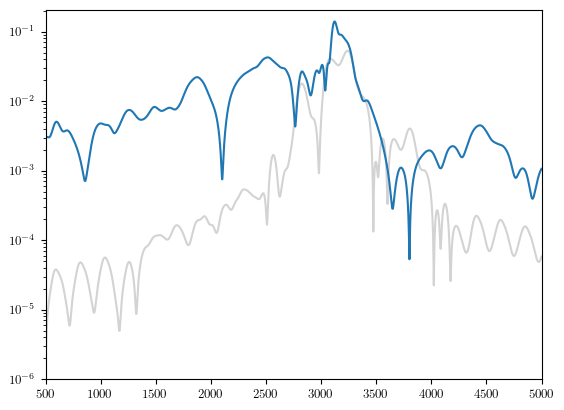

In [23]:
plt.semilogy(frequencies, jnp.abs(PM_strain)/jnp.sum(jnp.abs(PM_strain))*1e2)
plt.xlim(500,5000)
plt.ylim(1e-6,)
plt.semilogy(frequencies, jnp.abs(detector.filter_functions[jnp.argmax(expected_signal_photon_count)]).T, color='lightgrey',zorder=-100)
plt.show()

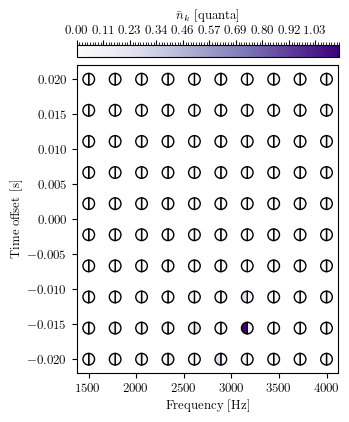

In [24]:
# Make plot for the n_exp_photons 

fig = GWPhotonCounting.plotting.generate_count_plot(expected_signal_photon_count, detector)

In [25]:
poisson_likelihood = GWPhotonCounting.distributions.PoissonPhotonLikelihood()

Observed photons count:  4


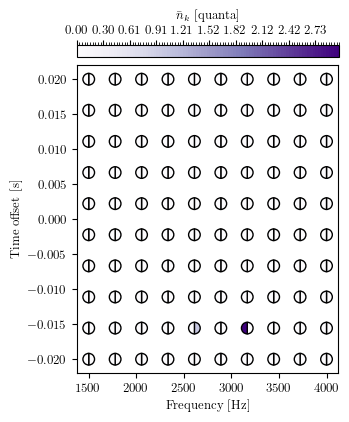

In [28]:
observed_photons = poisson_likelihood.generate_realization(expected_signal_photon_count)

print('Observed photons count: ', jnp.sum(observed_photons))

fig = GWPhotonCounting.plotting.generate_count_plot(observed_photons, detector)

In [10]:
# def indiv_filter_likelihood(n, n_obs, n_bar_sig, n_bar_cl):
    
#     return dist.Geometric(1/(n_bar_cl+1)).log_prob(n) + dist.Poisson(n_bar_sig).log_prob(n_obs-n)

# def loglikelihood_function(n_obs, n_bar_sig, n_bar_cl):
    
#     logl = 0
    
#     n_max = 3#jnp.max(n_obs)
#     n_idx_array = jnp.linspace(0,n_max, n_max+1, dtype=int)
    
#     logl_vmap_n_indiv = jax.vmap(indiv_filter_likelihood, in_axes=(0,None, None, None))
#     logl_vmap_ntot = jax.vmap(logl_vmap_n_indiv, in_axes=(None,0,0,0))
    
#     logl_m_n = logl_vmap_ntot(n_idx_array, n_obs, n_bar_sig, n_bar_cl)
    
#     logl_n = jax.scipy.special.logsumexp(logl_m_n, axis=1)
    
#     logl = jnp.sum(logl_n)
        
#     return logl


In [29]:
poisson_likelihood(observed_photons, expected_signal_photon_count)

Array(-11.69397616, dtype=float64)

In [12]:
def model(n_true_bank):
    
    A = numpyro.sample('A', dist.Uniform(0,1e-19))
    f0 = numpyro.sample('f0', dist.Uniform(1.5e3, 4e3))
    gamma = numpyro.sample('gamma', dist.Uniform(10,2e3))
    phase = numpyro.sample('phase', dist.Uniform(0,jnp.pi)) # TODO maybe this only needs to be half of the range
    t0s = jnp.linspace(-0.02, 0.02, 100)
    
    n_pm_model = LorentzianModel.generate_photon_count(detector, frequencies, f0=f0, gamma=gamma, A=A, phase=phase, t0=t0s)
    
    #logl_pm_and_noise_bank = loglikelihood_function(n_true_bank, n_pm_model, detector.noise_photon_expectation)
    #logl_noise_bank = loglikelihood_function(n_true_bank, 1e-16*jnp.ones(detector.N_total_filters), detector.noise_photon_expectation)
    
    logl_pm = loglikelihood_function_poisson(n_true_bank, n_pm_model)
    
    #numpyro.factor('log_likelihood', logl_pm_and_noise_bank - logl_noise_bank)
    numpyro.factor('log_likelihood', logl_pm)

In [13]:
n_warmup = 1000
n_sample = 1000
n_chains = 2

kernel = NUTS(model, target_accept_prob=0.8)
mcmc = MCMC(kernel, num_warmup=n_warmup, num_samples=n_sample, num_chains=n_chains)
mcmc.run(jax.random.PRNGKey(np.random.randint(1<<32)), n_obs_bank)

fit_lorentzian_n = az.from_numpyro(mcmc)

NameError: name 'NUTS' is not defined

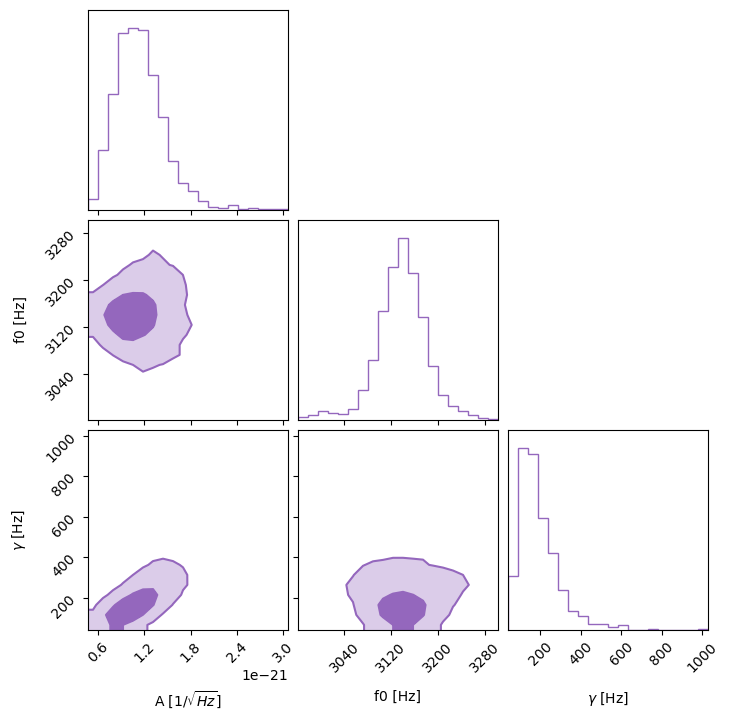

In [ ]:
from corner import corner

fig = corner(fit_lorentzian_n.posterior, plot_datapoints=False, fill_contours=True, plot_density=False, color='C4', levels=[0.5,0.9], smooth=0.7, 
      var_names=['A', 'f0', 'gamma'], labels=[r'A [1/$\sqrt{Hz}$]', 'f0 [Hz]', r'$\gamma$ [Hz]'], hist_kwargs={'density':True}, truths=[None, None, None], truth_color='k')

array([[<AxesSubplot: title={'center': 'A'}>,
        <AxesSubplot: title={'center': 'A'}>],
       [<AxesSubplot: title={'center': 'f0'}>,
        <AxesSubplot: title={'center': 'f0'}>],
       [<AxesSubplot: title={'center': 'gamma'}>,
        <AxesSubplot: title={'center': 'gamma'}>],
       [<AxesSubplot: title={'center': 'phase'}>,
        <AxesSubplot: title={'center': 'phase'}>]], dtype=object)

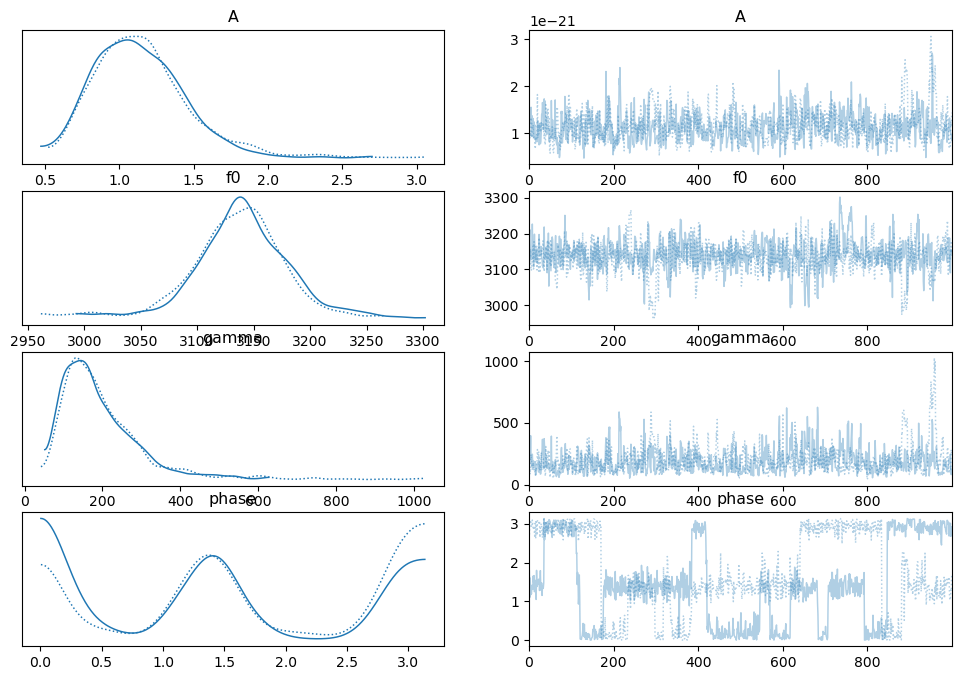

In [ ]:
az.plot_trace(fit_lorentzian_n)